# Lyrics Emotions Project

## Our Data

Before doing anything with data, we need to import the necessary libraries to read and manipulate the data.

In [0]:
import pandas as pd

In [2]:
single_label = pd.read_csv('SingleLabel.csv', encoding='utf-8')
single_label.head()

artist  ...       label
0         Nirvana  ...     Sadness
1   Damian Marley  ...     Tension
2  The Mission UK  ...  Tenderness
3            UB40  ...     Sadness
4     Johnny Cash  ...     Sadness

[5 rows x 7 columns]

The above dataset contains several headers that give us information on the collected songs, such as the artist, genre, title, etc. The final column, "label", along with the "lyrics" column is to be used for the Classification problem.

In [3]:
multi_label = pd.read_csv('MultiLabel.csv', encoding='utf-8')
multi_label.head()

artist  ...                                      labels
0         Nirvana  ...                           Calmness, Sadness
1   Damian Marley  ...                              Power, Tension
2  The Mission UK  ...  Amazement, Calmness, Solemnity, Tenderness
3            UB40  ...         Joyful activation, Sadness, Tension
4     Johnny Cash  ...      Amazement, Calmness, Joyful activation

[5 rows x 7 columns]

This dataset contains the same information but differs in the final column, with it being labels and containing multiple labels for each example. This dataset is to be used for the Multi-Label Classification problem.

## Data Exploration and Preprocessing

Let's take a look at the classes distribution, before transforming the data to model-interpretable format.

In [4]:
single_label['label'].value_counts()

Sadness       569
Tenderness    326
Tension       265
Name: label, dtype: int64

Sadness is the most represented class, with Tenderness and Tension following.

Next we plot the word cloud of the top 100 words in each class.

In [5]:
from wordcloud import WordCloud, STOPWORDS
sadness = single_label.loc[single_label['label']=="Sadness"]
tension = single_label.loc[single_label['label']=="Tension"]
tenderness = single_label.loc[single_label['label']=="Tenderness"]
sadness_wordcloud = WordCloud(
    width = 300,
    height = 300,
    max_words=100,
    background_color = 'white',
    stopwords = STOPWORDS).generate(" ".join(sadness['lyrics']))
sadness_wordcloud.to_file("sadness.png")

tension_wordcloud = WordCloud(
    width = 300,
    height = 300,
    max_words=100,
    background_color = 'white',
    stopwords = STOPWORDS).generate(" ".join(tension['lyrics']))
tension_wordcloud.to_file("tension.png")

tenderness_wordcloud = WordCloud(
    width = 300,
    height = 300,
    max_words=100,
    background_color = 'white',
    stopwords = STOPWORDS).generate(" ".join(tenderness['lyrics']))
tenderness_wordcloud.to_file("tenderness.png")

The word clouds show that there is a significant overlap of top words among classes.

## A: Single-Label Classification

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

We had observed that the dataset is imbalanced. Conventional algorithms tend to be biased towards the majority class incase of imbalanced dataset. We will deal with this issue by applying both undersampling and oversampling techniques. 

In [0]:
sadness = sadness.sample(n = 265)
tenderness = tenderness.sample(n = 265)
single_label_under_sampled = pd.concat([sadness.sample(n=265), tenderness.sample(n=265), tension])
single_label_over_sampled =  pd.concat([sadness, pd.concat([tenderness.sample(n=243), tenderness]), pd.concat([tension.sample(n=304, replace = True), tension])])

After importing the neccessary libraries, we split the data in X and y (the "lyrics" data and the "label" data) for both under sampled and over sampled

In [0]:
X = single_label['lyrics']
X_under_sampled = single_label_under_sampled['lyrics']
X_over_sampled = single_label_over_sampled['lyrics']

In [0]:
y = single_label['label']
y_under_sampled = single_label_under_sampled['label']
y_over_sampled = single_label_over_sampled['label']

We then define our classifier as a LinearSVC and create a pipeline that first transforms the data and then feeds it into the Machine Learning classifier.

In [0]:
clf = LinearSVC(random_state=0, tol=1e-5, max_iter = 2000)

Raw text data needs to be converted to feature vectors for the classifier algorithms to work. We convert the lyrics into features in two different ways and perform the classification seperately for each of them.

*   Count Vectorizer    
*   TF/IDF Vectorizer



###  Count Vectorizer
We setup a Count Vectorizer to convert our lyrics into features.


In [0]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(min_df=3,
                              max_features = 3000,
                              strip_accents='unicode',
                              lowercase = True,
                              analyzer = 'word', 
                              token_pattern=r'\w{3,}',
                              ngram_range=(1,1),
                              stop_words = "english")    

Now that we have both the classifier and vectorizer, we define a function that will do the following

1.   Setup pipeline
2.   Fit the training data
3.   Produce a classification report



In [0]:
def svm_classification(X_train, y_train, X_test, y_test, vectorizer_):
  clf = LinearSVC(random_state=0, tol=1e-5, max_iter = 2000)
  pipeline = make_pipeline(vectorizer_, clf)
  pipeline.fit(X_train, y_train)
  y_pred = pipeline.predict(X_test)
  print('ACCURACY :', accuracy_score(y_pred, y_test))
  print('REPORT :', classification_report(y_pred, y_test))
  return y_pred

Now, that we have our model, we split into training and test sets to calculate our classifier's efficiency in classifying lyrics into one of the three emotion classes.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)
X_under_sampled_train, X_under_sampled_test, y_under_sampled_train, y_under_sampled_test = train_test_split(X_under_sampled, y_under_sampled, test_size=0.25, random_state = 42)
X_over_sampled_train, X_over_sampled_test, y_over_sampled_train, y_over_sampled_test = train_test_split(X_over_sampled, y_over_sampled, test_size=0.25, random_state = 42)

Finally, we fit our model with the training data and validate it on our test data. The metrics used are overall accuracy and precision, recall and f1-score for each class.

In [14]:
y_pred = svm_classification(X_under_sampled_train, y_under_sampled_train,X_under_sampled_test, y_under_sampled_test, cv)

ACCURACY : 0.47738693467336685
REPORT :               precision    recall  f1-score   support

     Sadness       0.34      0.33      0.34        64
  Tenderness       0.59      0.58      0.59        67
     Tension       0.49      0.51      0.50        68

    accuracy                           0.48       199
   macro avg       0.47      0.47      0.47       199
weighted avg       0.48      0.48      0.48       199



We perform the same steps but with oversampled data.

In [15]:
y_pred = svm_classification(X_over_sampled_train, y_over_sampled_train,X_over_sampled_test, y_over_sampled_test, cv)

ACCURACY : 0.7886904761904762
REPORT :               precision    recall  f1-score   support

     Sadness       0.33      0.51      0.40        39
  Tenderness       0.91      0.86      0.88       145
     Tension       0.88      0.80      0.83       152

    accuracy                           0.79       336
   macro avg       0.70      0.72      0.70       336
weighted avg       0.83      0.79      0.80       336



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


We perform cross validation with the best dataset to ensure that our model does not overfit and generalizes well to new data.

In [16]:
from sklearn.model_selection import cross_val_score
clf = LinearSVC(random_state=0, tol=1e-5, max_iter = 2000)
pipeline = make_pipeline(cv, clf)
scores = cross_val_score(pipeline, X_over_sampled, y_over_sampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Accuracy: 0.82 (+/- 0.10)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


### TF/IDF Vectorizer
We set up a TF/IDF Vectorizer to transform our lyrics into features that indicate their belonging to one of the three classes.

In [0]:
tfv = TfidfVectorizer(min_df=3,
                      max_features=3000,
                      strip_accents='unicode',
                      lowercase =True,
                      analyzer='word',
                      token_pattern=r'\w{3,}',
                      ngram_range=(1,1),
                      use_idf=True,
                      smooth_idf=True,
                      sublinear_tf=True,
                      stop_words = "english")

We repeat the same steps we performed with Count Vectorizer with just a small change of the vectorizer.

In [18]:
y_pred = svm_classification(X_train, y_train, X_test, y_test, tfv)

ACCURACY : 0.6103448275862069
REPORT :               precision    recall  f1-score   support

     Sadness       0.73      0.63      0.68       175
  Tenderness       0.52      0.61      0.56        70
     Tension       0.42      0.53      0.47        45

    accuracy                           0.61       290
   macro avg       0.56      0.59      0.57       290
weighted avg       0.63      0.61      0.62       290



We plot the Confusion matrix to see which classes are confused the most.

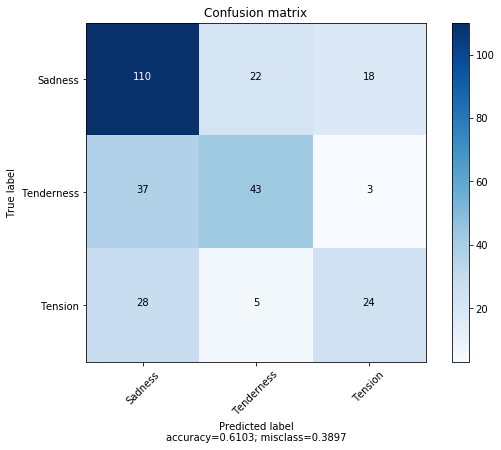

In [19]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['Sadness', 'Tenderness', 'Tension']

#Citation : https://stackoverflow.com/a/50386871/3215142
def plot_confusion_matrix(file_name,
                          cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    https://stackoverflow.com/a/50386871/3215142
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(file_name)
cm = confusion_matrix(y_test, y_pred, labels)
plot_confusion_matrix("svm_tfv_confusion_matrix.png", cm, labels, cmap = plt.cm.Blues, normalize = False)    

We repeat the above steps for under sampled data

In [20]:
y_pred = svm_classification(X_under_sampled_train, y_under_sampled_train,X_under_sampled_test, y_under_sampled_test, tfv)

ACCURACY : 0.6030150753768844
REPORT :               precision    recall  f1-score   support

     Sadness       0.46      0.43      0.44        65
  Tenderness       0.71      0.68      0.70        69
     Tension       0.62      0.69      0.66        65

    accuracy                           0.60       199
   macro avg       0.60      0.60      0.60       199
weighted avg       0.60      0.60      0.60       199



We plot the Confusion matrix to see which classes are confused the most.

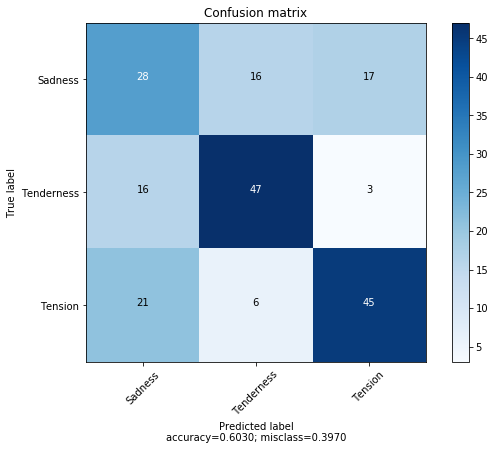

In [21]:
cm = confusion_matrix(y_under_sampled_test, y_pred, labels)
plot_confusion_matrix("svm_tfv_under_sampled_confusion_matrix.png", cm, labels, cmap = plt.cm.Blues, normalize = False)

We perform the same steps but with over sampled data.

In [22]:
y_pred = svm_classification(X_over_sampled_train, y_over_sampled_train,X_over_sampled_test, y_over_sampled_test, tfv)

ACCURACY : 0.8095238095238095
REPORT :               precision    recall  f1-score   support

     Sadness       0.21      0.62      0.32        21
  Tenderness       0.93      0.87      0.90       146
     Tension       0.96      0.78      0.86       169

    accuracy                           0.81       336
   macro avg       0.70      0.76      0.69       336
weighted avg       0.90      0.81      0.84       336



We plot the Confusion matrix to see which classes are confused the most.

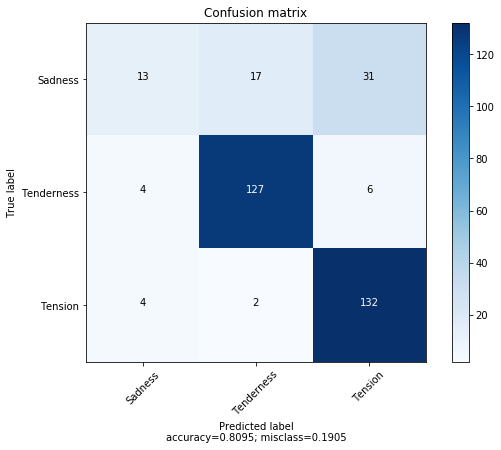

In [23]:
cm = confusion_matrix(y_over_sampled_test, y_pred, labels)
plot_confusion_matrix("svm_tfv_over_sampled_confusion_matrix.png", cm, labels, cmap = plt.cm.Blues, normalize = False)

Now we perform cross validation to ensure that our model does not overfit and generalizes well to new data.

In [24]:
from sklearn.model_selection import cross_val_score
clf = LinearSVC(random_state=0, tol=1e-5, max_iter = 2000)
pipeline = make_pipeline(tfv, clf)
scores = cross_val_score(pipeline, X_over_sampled, y_over_sampled, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.83 (+/- 0.05)


## B: Multi-Label Classification

First we are going to take a look at the distribution of labels in our dataset.

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(', '))
emotion_dtm = vectorizer.fit_transform(multi_label['labels'])
print('Number of data points:', emotion_dtm.shape[0])
print('Number of unique emotions:', emotion_dtm.shape[1])

Number of data points: 1160
Number of unique emotions: 9


In [26]:
emotions = vectorizer.get_feature_names()
freqs = emotion_dtm.sum(axis=0).A1
result = dict(zip(emotions, freqs))
freq_count = pd.DataFrame(result.items(), columns=['Emotions', 'Counts'])
freq_sorted = freq_count.sort_values(['Counts'], ascending=False)
freq_sorted

Emotions  Counts
5            sadness     574
8            tension     553
7         tenderness     498
4              power     477
3          nostalgia     438
6          solemnity     377
2  joyful activation     349
1           calmness     250
0          amazement     239

In [27]:
emotion_per_example = emotion_dtm.sum(axis=1).tolist()
emotion_per_example = [int(j) for i in emotion_per_example for j in i]
print('Maximum emotions per example: %d'%max(emotion_per_example))
print('Minimum emotions per example: %d'%min(emotion_per_example))
print('Average emotions per example: %f'% ((sum(emotion_per_example))/len(emotion_per_example)))

Maximum emotions per example: 7
Minimum emotions per example: 1
Average emotions per example: 3.237069


After taking a closer look at the data in hand, we proceed with solving the classification problem.

In [0]:
from sklearn.preprocessing import MultiLabelBinarizer

For this task we will need a Binarizer for the labels. As each example is annotated as more than one classes, we need to transform this information to a machine-readable format. But first, let's create X and y.

In [29]:
X = multi_label['lyrics']
X.head()

0    I will never bother you\nI will never promise ...
1    Here we go\nMy big ego is gonna get me in trou...
2    She came as Lolita dressed as Venus\nAnd adorn...
3    Ivory Madonna, dying in the dust\nWaiting for ...
4    I was totin' my pack along the dusty Winnemucc...
Name: lyrics, dtype: object

In [30]:
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(multi_label['labels'])
y

array([[1, 1, 0, ..., 0, 0, 0],
       [1, 1, 0, ..., 1, 0, 0],
       [1, 1, 1, ..., 0, 1, 1],
       ...,
       [1, 1, 0, ..., 1, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 0, 1]])

In the line above, our labels are transformed into arrays, where 1 indicates the presence of a specific class.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier

For this problem we are using Logistic Regression-trained classifiers for each class, with the help of the OneVsRestClassifier. The data is again fed into the classifier via a pipeline, where it is transformed into vectors of TF/IDF features.

In [0]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)
pipeline = make_pipeline(tfv, clf)

Now, that we have our model, we once again split into training and test sets to calculate our classifier's efficiency in classifying lyrics into sets of emotions' labels.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 42)

Before we fit our classifiers, we import the f1-score metric to evaluate the efficiency of learning of our model.

In [0]:
from sklearn.metrics import f1_score

This time the average setting of f1_score is set to micro in order to aggregate the contributions of all classes and compute the average metric.

In [35]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print('F1-SCORE :',f1_score(y_test, y_pred, average="micro"))
print('REPORT :', classification_report(y_pred, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1-SCORE : 0.8244719592134012
REPORT :               precision    recall  f1-score   support

           0       1.00      0.97      0.98       290
           1       1.00      0.97      0.98       290
           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       0.09      0.89      0.17         9
           5       0.15      0.67      0.24        27
           6       0.41      0.81      0.55        62
           7       0.99      0.73      0.84       270
           8       1.00      0.76      0.86       290
           9       1.00      0.91      0.95       290
          10       0.09      0.89      0.17         9
          11       0.99      0.75      0.86       269
          12       1.00      1.00      1.00       290
          13       0.09      0.89      0.17         9
          14       0.15      0.67      0.24        27
          15       1.00      0.94      0.97       290
          16       1.00      0.84      0.9

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
